# PSO Fitting Testing

In [1]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

## Do 12-005 S2

Removing means (['M00: 572.78', 'M02: 118251.72', 'M11: 12787.84', 'M12: -142800.68', 'M20: 80173.9', 'M21: -112306.35', 'M22: 52262131.65']) 
Scaling standard deviations (['M00: 386.2', 'M02: 154667.97', 'M11: 124106.3', 'M12: 1342767.19', 'M20: 94607.6', 'M21: 1143759.61', 'M22: 145068970.21']) to be 1


<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

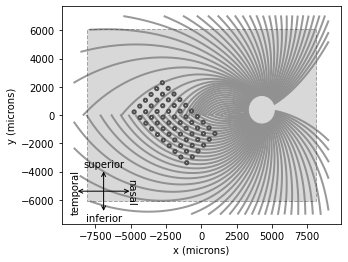

In [2]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2)
model.xystep=0.5

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y[0].shape

estimator = shapes.BiphasicAxonMapEstimator(implant=implant, model=model, resize=True, mse_params=['moments_central'])
search_params = {
    'a5' : (-1, 5),
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)

y_moments = estimator.compute_moments(y)
model.build()
model.plot()
implant.plot()

In [ ]:
estimator.score(x, y_moments)
opt.fit(x, y_moments)
estimator.score(x, y_moments)

In [ ]:
params1 = estimator.get_params()
params1

score=7.531, rho=66.9, lambda=708.0, a5=0.843, a6=-0.054, mses: ['M00: 1.207', 'M02: 1.165', 'M11: 0.861', 'M12: 1.057', 'M20: 1.179', 'M21: 1.018', 'M22: 1.044']


7.531016018576825

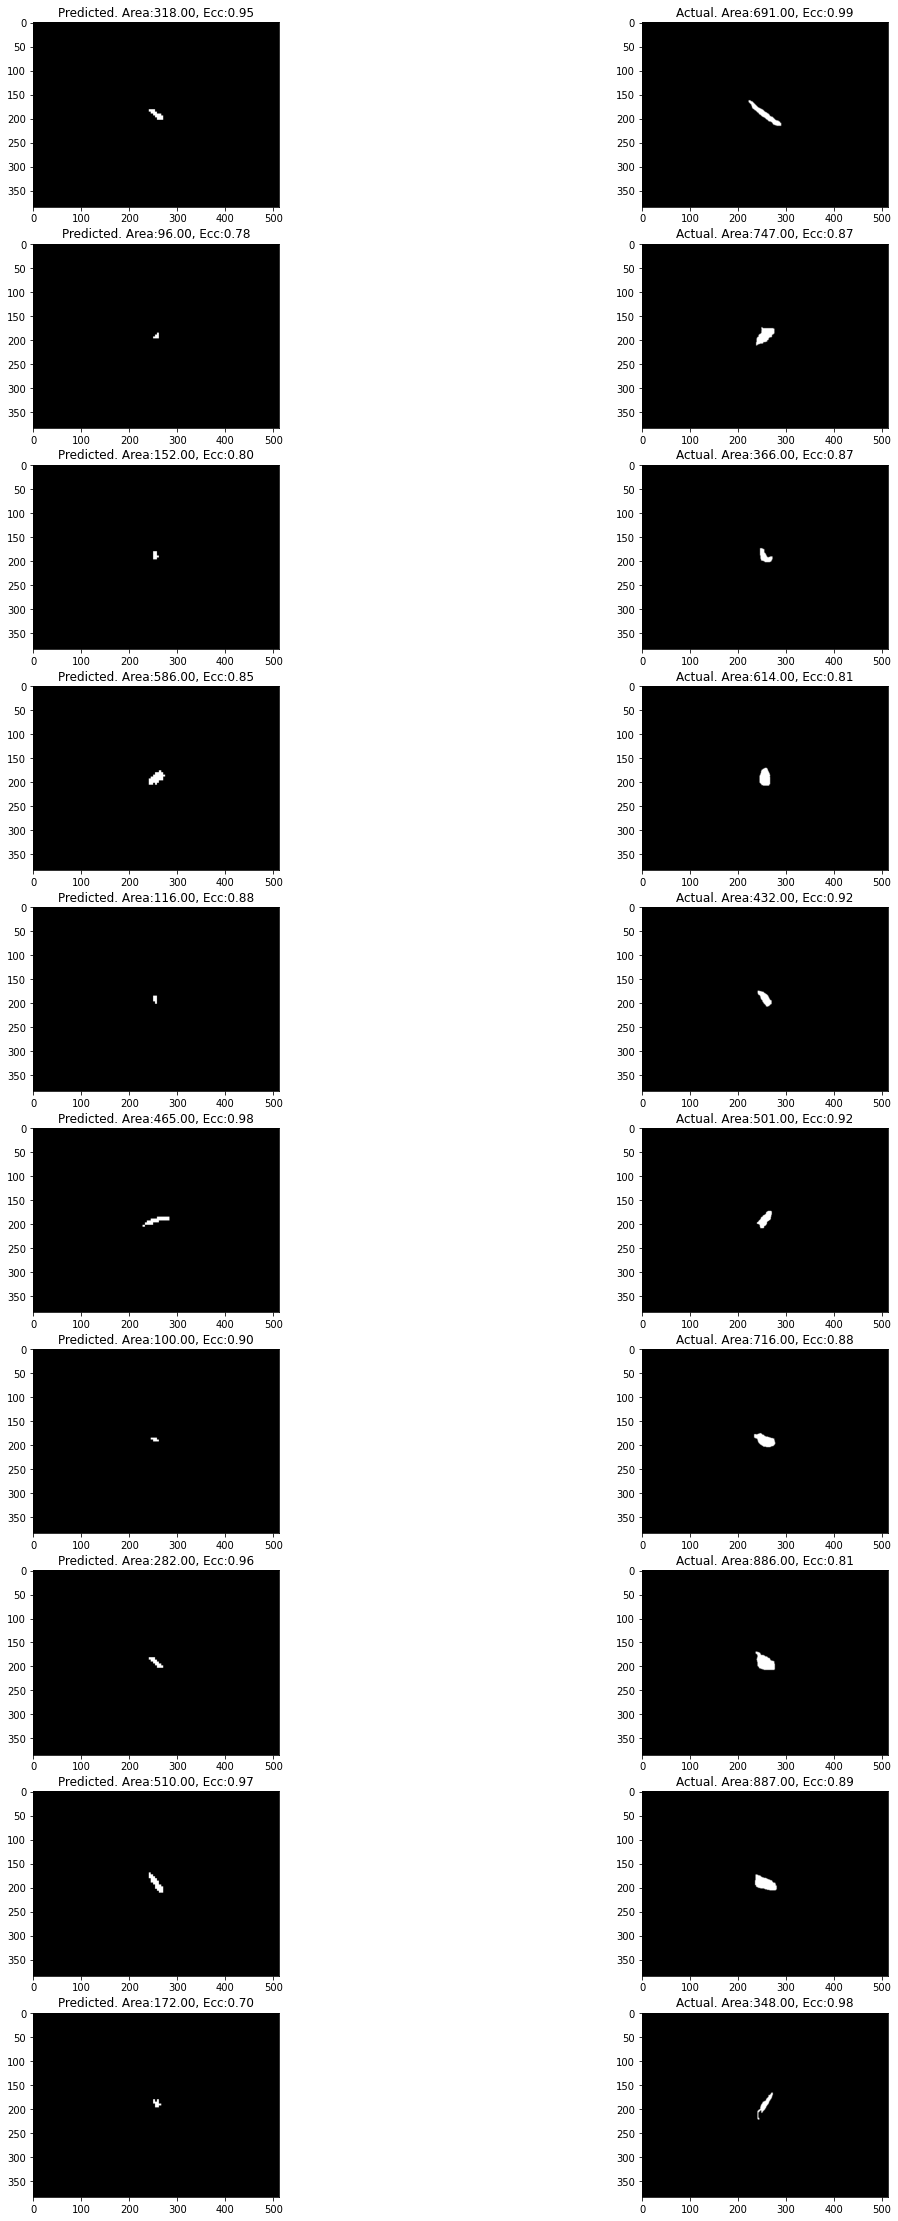

In [21]:
import random
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
estimator.set_params(**params1)
estimator.fit(x, y)
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample([i for i in range(len(x))], 10)):
    img = resize(center_image(preds[img_idx] > (preds[img_idx].max() - preds[img_idx].min()) * 0.1 + preds[img_idx].min()), y[img_idx].shape)
    area = np.sum(img)
    axes[plt_idx, 0].imshow(img, cmap="gray")
    props = measure.regionprops(measure.label(img))
    axes[plt_idx, 0].set_title("Predicted. Area:%.2f, Ecc:%.2f" % (area, props[0].eccentricity))
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    props = measure.regionprops(measure.label(center_image(y[img_idx])))
    prop = max(props, key = lambda x : x.area)
    axes[plt_idx, 1].set_title("Actual. Area:%.2f, Ecc:%.2f" % (np.sum(center_image(y[img_idx])), prop.eccentricity))
fig.show()
estimator.score(x, y_moments)

### Unstandardized mses

In [4]:
estimator.mse_params = ['moments_central', "area", "eccentricity", "major_axis_length", "minor_axis_length", "orientation"]
estimator.scale_features = False
new_y_moments = estimator.compute_moments(y, fit_scaler=False)
estimator.score(x, new_y_moments)

Warning, got different length feature_importances and mse_params. Did you set one manually?
Defaulting to equal weighting
score=11791400626093288.000, rho=200.0, lambda=200.0, a5=1.081, a6=-0.353, mses: ['M00: 547970.197', 'M02: 37707208160.562', 'M11: 8851765103.171', 'M12: 175017656640.709', 'M20: 23336645998.738', 'M21: 106765878002.187', 'M22: 1.1791048945841724e+16', 'area: 547970.197', 'eccentricity: 0.229', 'major_axis_length: 1371.235', 'minor_axis_length: 346.584', 'orientation: 1.003']


1.1791400626093288e+16

### Standardized mses

In [6]:
estimator.mse_params = ['moments_central', "area", "eccentricity", "major_axis_length", "minor_axis_length", "orientation"]
estimator.scale_features=True
new_y_moments = estimator.compute_moments(y, fit_scaler=True)
estimator.score(x, new_y_moments)

Removing means (['M00: 560.18', 'M02: 95102.63', 'M11: 24202.46', 'M12: -46893.36', 'M20: 65115.72', 'M21: -50567.79', 'M22: 31353163.63', 'area: 560.18', 'eccentricity: 0.87', 'major_axis_length: 58.04', 'minor_axis_length: 18.48', 'orientation: 0.06']) 
Scaling standard deviations (['M00: 392.19', 'M02: 130835.05', 'M11: 93802.57', 'M12: 416635.68', 'M20: 76773.64', 'M21: 322264.26', 'M22: 102740688.22', 'area: 392.19', 'eccentricity: 0.15', 'major_axis_length: 29.93', 'minor_axis_length: 9.21', 'orientation: 0.94']) to be 1
score=33.902, rho=200.0, lambda=200.0, a5=1.081, a6=-0.353, mses: ['M00: 3.563', 'M02: 2.203', 'M11: 1.006', 'M12: 1.008', 'M20: 3.959', 'M21: 1.028', 'M22: 1.117', 'area: 3.563', 'eccentricity: 9.699', 'major_axis_length: 1.531', 'minor_axis_length: 4.082', 'orientation: 1.143']


33.90164057294065

## Fit size model first

Removing means (['M00: 560.18', 'M02: 95102.63', 'M11: 24202.46', 'M12: -46893.36', 'M20: 65115.72', 'M21: -50567.79', 'M22: 31353163.63']) 
Scaling standard deviations (['M00: 392.19', 'M02: 130835.05', 'M11: 93802.57', 'M12: 416635.68', 'M20: 76773.64', 'M21: 322264.26', 'M22: 102740688.22']) to be 1
a5=0.224807, a6=0.718991


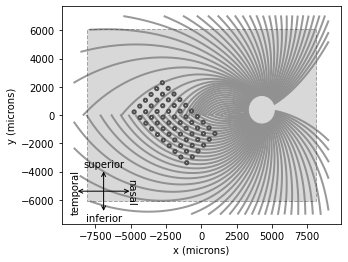

In [23]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2)
model.xystep=0.5

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y[0].shape

estimator = shapes.BiphasicAxonMapEstimator(implant=implant, model=model, resize=True, mse_params=['moments_central'])
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)

y_moments = estimator.compute_moments(y)
model.build()
model.plot()
implant.plot()
estimator.fit_size_model(x['amp1'], y)

In [25]:
estimator.score(x, y_moments)
opt.fit(x, y_moments)
estimator.score(x, y_moments)

score=7.578, rho=200.0, lambda=200.0, a5=0.225, a6=0.719, mses: ['M00: 1.273', 'M02: 1.131', 'M11: 1.021', 'M12: 1.007', 'M20: 1.042', 'M21: 1.023', 'M22: 1.081']
score=602793.591, rho=937.4, lambda=1969.3, a5=0.225, a6=0.719, mses: ['M00: 2043.961', 'M02: 88412.673', 'M11: 3625.763', 'M12: 149045.528', 'M20: 95230.717', 'M21: 89992.97', 'M22: 174441.979']
score=537.338, rho=173.6, lambda=1696.1, a5=0.225, a6=0.719, mses: ['M00: 17.213', 'M02: 97.322', 'M11: 57.728', 'M12: 94.819', 'M20: 53.83', 'M21: 172.434', 'M22: 43.993']
score=2172.603, rho=582.2, lambda=419.2, a5=0.225, a6=0.719, mses: ['M00: 188.03', 'M02: 528.455', 'M11: 2.989', 'M12: 16.43', 'M20: 1314.234', 'M21: 14.367', 'M22: 108.097']
score=2353.823, rho=286.6, lambda=1726.4, a5=0.225, a6=0.719, mses: ['M00: 63.321', 'M02: 445.414', 'M11: 205.531', 'M12: 399.728', 'M20: 289.579', 'M21: 704.473', 'M22: 245.777']
score=10713.655, rho=719.3, lambda=393.6, a5=0.225, a6=0.719, mses: ['M00: 434.396', 'M02: 2490.028', 'M11: 3.808

7.5170726481794405

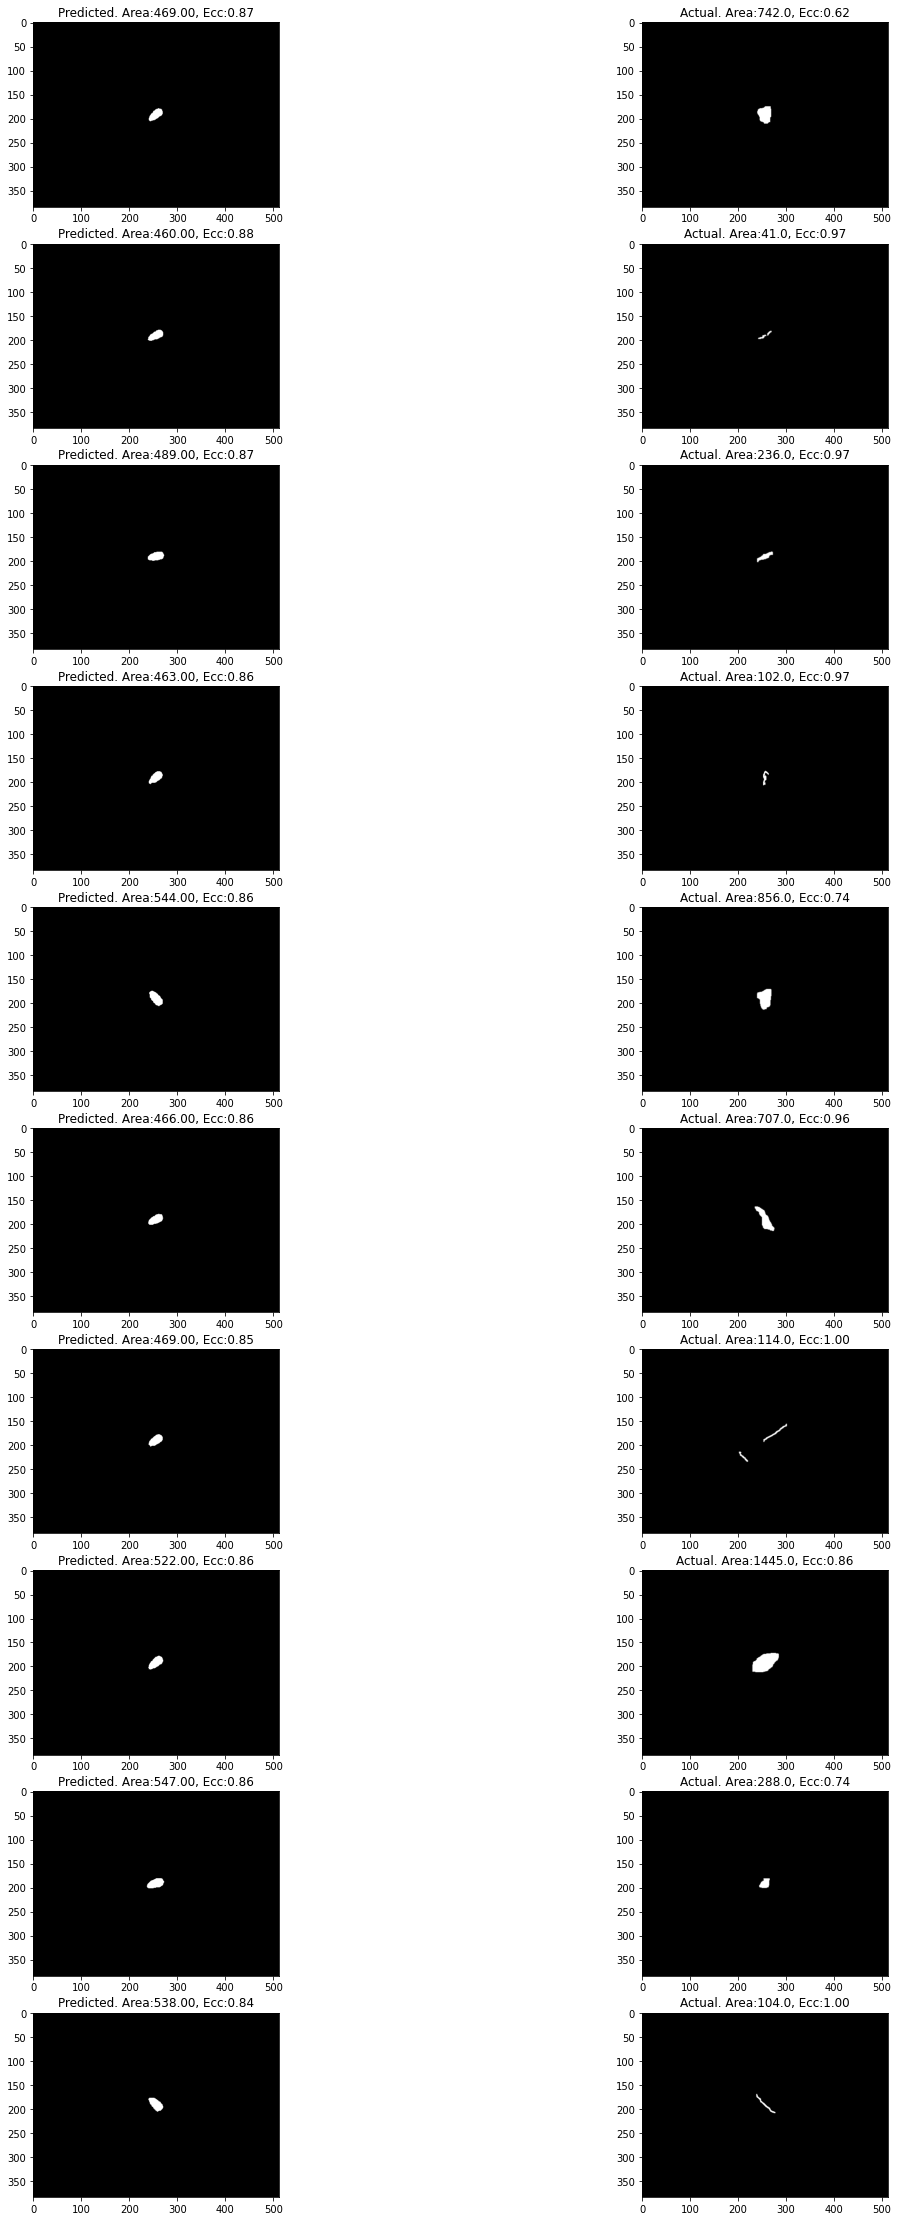

In [13]:
import random
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample([i for i in range(len(x))], 10)):
    axes[plt_idx, 0].imshow(resize(center_image(preds[img_idx] > 1), y[img_idx].shape), cmap="gray")
    props = measure.regionprops(measure.label(resize(center_image(preds[img_idx] > 1), y[img_idx].shape)))
    axes[plt_idx, 0].set_title("Predicted. Area:%.2f, Ecc:%.2f" % (props[0].area, props[0].eccentricity))
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    props = measure.regionprops(measure.label(center_image(y[img_idx])))
    prop = max(props, key = lambda x : x.area)
    axes[plt_idx, 1].set_title("Actual. Area:%.2f, Ecc:%.2f" % (prop.area, prop.eccentricity))
fig.show()
estimator.score(x, y_moments)

## AxonMap

In [ ]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

In [4]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2, biphasic=False)
model.xystep=0.5

# CHANGING relative_weight will be VERY important
relative_weight=1e-5
estimator = shapes.AxonMapEstimator(implant=implant, model=model, relative_weight=relative_weight)
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=200, swarm_size=100, has_loss_function=True)

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']


In [5]:
estimator.score(x, y)
opt.fit(x, y)

rho=200.000000, axlambda=200.000000, score=3.313693
rho=865.065426, axlambda=511.488464, score=736.317361
rho=623.359468, axlambda=1433.896854, score=441.032700
rho=52.309691, axlambda=1365.957181, score=3.348423
rho=513.345329, axlambda=1051.956610, score=172.017450
rho=345.337464, axlambda=578.350006, score=21.184348
rho=967.494666, axlambda=333.947320, score=1079.584845
rho=117.891668, axlambda=127.351093, score=3.353498
rho=527.337622, axlambda=1396.180390, score=258.374088
rho=266.646532, axlambda=1200.504484, score=27.303176
rho=411.059125, axlambda=1957.105768, score=193.508744
rho=522.416779, axlambda=538.924885, score=102.062989
rho=372.574419, axlambda=1008.836710, score=58.117108
rho=273.959778, axlambda=738.851658, score=12.676989
rho=827.729154, axlambda=997.756340, score=826.905911
rho=935.081598, axlambda=1412.794951, score=1573.976505
rho=575.998212, axlambda=966.455609, score=231.525601
rho=332.940614, axlambda=374.473690, score=11.701792
rho=542.691670, axlambda=1957.

KeyboardInterrupt: 